# Clustering For Lubmarine (Partie 2): Clustering

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

### Context
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.


### Table of contents: 
1. [Data Loading](#first-chapter)
2. [Data cleaning](#second-chapter)
3. [CLustering](#third-chapter) <br>
a. [RFM parameters](#first-bullet) <br>
b. [RFM + KMeans Model](#second-bullet)<br>
c. [Customers Segmentation with RFM-KMeans](#third-bullet)<br>
d. [Agglomerative Hierarchical Clustering](#d-bullet)

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# 1. Chargement des données <a class="anchor" id="first-chapter"></a>

In [2]:
# fixer les parmètres de figure plt
plt.rcParams.update({'figure.figsize': (15, 10), 'axes.labelsize': 15, 'axes.titlesize':25, 
                     'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.titleweight':'bold','axes.titleweight':'bold'})

# Charger les données 
path = "C:/Users/ibrah/Desktop/laplateforme/clustring/clustring/data"
data = []
names = []
filesize = {}
for file in os.listdir(path):
    if file[:5] == 'olist':
        name = file[6:-12]
    else:
        name = file[17:-4]
    locals()[name] = pd.read_csv(os.path.join(path, file), sep =",")
    data.append(locals()[name])
    names.append(name)
    filesize[name]= locals()[name].shape
    print(name)
    
# fonction qui indique les colonnes en commun entre les fichiers
def same_col(folder):
    for i in range(len(folder)):
        files = folder.copy()
        nam = names.copy()
        files.pop(i)
        nam.pop(i)
        for j in range(len(files)):
            for col_a in folder[i].columns.values.tolist():
                for col_b in files[j].columns.values.tolist():
                    if col_a == col_b:
                        print('{}/{}:{}'.format(names[i],nam[j],col_b))
        print('')

# same_col(data)

customers
geolocation
orders
order_items
order_payments
order_reviews
products
sellers
name_translation


## 2. Nettoyage et préparation des données <a class="anchor" id="second-chapter"></a>

In [ ]:
# retirer les variables qui ne nous intéressent pas
reviews_clean = order_reviews.drop(['review_comment_title','review_comment_message','review_answer_timestamp'], axis=1)
product_clean = products[['product_id','product_category_name','product_photos_qty']]
order_clean = orders.drop(['order_approved_at','order_delivered_carrier_date'], axis=1)
order_clean = pd.merge(order_clean, order_items)

# merge des fichiers cleans
pd_clean = pd.merge(customers, order_clean)
pd_clean = pd.merge(pd_clean, reviews_clean)
pd_clean = pd.merge(pd_clean, order_payments)
pd_clean = pd.merge(pd_clean,product_clean)
pd_clean = pd.merge(pd_clean, sellers)
pd_clean = pd.merge(pd_clean,name_translation)
pd_clean = pd_clean.drop("product_category_name", axis=1)
pd_clean_ = pd.merge(pd_clean, sellers).rename(columns={"product_category_name_english":"category_name"})
# Gestion des NAN 
sns.heatmap(pd_clean_.isna(), cbar=False)
pd_clean = pd_clean_.dropna()
sns.heatmap(pd_clean.isna(), cbar=False)

In [ ]:
# conversion des colonnes dates
pd_clean.filter(like='date', axis=1)

def col2datetime(df):
    datelist = df.filter(like='date', axis=1).columns.values.tolist()
    for col in datelist:
        df[col] = pd.to_datetime(df[col])
    return df

# pd_clean = col2datetime(pd_clean)
pd_clean.info()
pd_clean.head()

In [ ]:
# Retirer les duplicats order_id, customer_id,order_purchase ... parce qu'ils ne peuvent qu'être relatifs à une seule et
# même commande
df = pd_clean
df = df.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'})
df = df[df.order_status == 'delivered']

## 3. Clustering <a class="anchor" id="third-chapter"></a>
### a. RFM : Recensy, Frequency, Monetary <a class="anchor" id="first-bullet"></a>

In [ ]:
# Calcul de la fréquence rFm
df['total_pay'] = df.payment_value * df.payment_installments
freq = df.groupby('customer_unique_id')['order_id'].count()

# Calcul de la monetary rfM
totalpaybycust = df.groupby('customer_unique_id')['payment_value'].sum()
totalpaybycust = totalpaybycust.reset_index(level='customer_unique_id', name='monetary')
pd_rfm = pd.merge(freq, totalpaybycust, on='customer_unique_id').rename(columns={'order_id':'frequency'})
# pd_rfm.sort_values(ascending=False, by='monetary')

In [ ]:
# Calcul de la recency Rfm
df_sort = df.sort_values(ascending=False, by='order_purchase_timestamp')

# Extraire les dates de commande les plus récentes pour chaque client
df_recency = df_sort.groupby('customer_unique_id')['order_purchase_timestamp'].first().sort_values()
df_rec = df_recency.copy()
df_recency = df_rec.reset_index(level='customer_unique_id', name='more_recent_purchase_date')
df_recency['more_recent_purchase_date'] = pd.to_datetime(df_recency['more_recent_purchase_date'])

# Définir la dernière date du dataset
max_date = pd.to_datetime(max(df['order_purchase_timestamp']))

# Calculer le nombre de jours depuis la dernière de chaque client (= recency)
df_recency['recency']= (max_date-df_recency['more_recent_purchase_date']).dt.days

pd_rfm = pd.merge(pd_rfm,df_recency.drop('more_recent_purchase_date',axis=1))
pd_rfm

In [ ]:
# Distribution des 3 paramètres 
plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1); sns.distplot(pd_rfm['recency'])
plt.subplot(3, 1, 2); sns.distplot(pd_rfm['frequency'])
plt.subplot(3, 1, 3); sns.distplot(pd_rfm['monetary'])
plt.show()

In [ ]:
# Outliers check in
plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1); sns.boxplot(pd_rfm['recency'])
plt.subplot(3, 1, 2); sns.boxplot(pd_rfm['frequency'])
plt.subplot(3, 1, 3); sns.boxplot(pd_rfm['monetary'])
plt.show()

In [ ]:
# Gestion des outliers for monetary
Q1 = pd_rfm.monetary.quantile(0.05)
Q3 = pd_rfm.monetary.quantile(0.95)
IQ = Q3-Q1
pd_rfm=pd_rfm[(pd_rfm['monetary']>=Q1-1.5*IQ) & (pd_rfm['monetary']<=Q3+1.5*IQ)]

In [ ]:
# Outliers check in
plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1); sns.boxplot(pd_rfm['recency'])
plt.subplot(3, 1, 2); sns.boxplot(pd_rfm['frequency'])
plt.subplot(3, 1, 3); sns.boxplot(pd_rfm['monetary'])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd_rfm_scaled = pd_rfm[['monetary', 'frequency', 'recency']]
scaler = StandardScaler()

# fit_transform
pd_rfm_scaled = pd.DataFrame(scaler.fit_transform(pd_rfm_scaled), columns=['monetary', 'frequency', 'recency'])
pd_rfm_scaled.describe()

In [ ]:
sns.heatmap(pd_rfm_scaled.corr())
pd_rfm_scaled.corr()
# à priori on ne peut pas établir de liens entre les 3 paramètres

### b. RFM + KMeans Model <a class="anchor" id="second-bullet"></a>

In [ ]:
# K means clustering for RFM 
k_means = KMeans(n_clusters=4, max_iter=50)
k_means.fit(pd_rfm_scaled)
Counter(k_means.labels_)

In [ ]:
# ssd = []
# sscores = []
# cluster_lab_max = []

# for i in range(1,10):
#     print(i)
#     n=i+1
#     k_means = KMeans(n_clusters=n, max_iter=50).fit(pd_rfm_scaled)
#     cluster_labels = k_means.labels_
#     # silhouette score
#     silhouette_avg = silhouette_score(pd_rfm_scaled, cluster_labels)    
#     ssd.append(k_means.inertia_)
#     sscores.append(silhouette_avg)
#     max_score = max(sscores)
#     if max_score < silhouette_avg:
#         n_cluster_max = i+1
#         max_score = silhouette_avg
#         cluster_lab_max = cluster_labels


# print(max_score)
# print(Counter(cluster_lab_max))
# inertia : Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

In [ ]:
import pickle

# Pickling files
# with open('ssd.txt', 'wb') as fh:
#    pickle.dump(ssd, fh)
  
pickle_off = open ("ssd.txt", "rb")
ssd = pickle.load(pickle_off)

# with open('sscores.txt', 'wb') as fh:
#    pickle.dump(sscores, fh)
  
pickle_off = open ("sscores.txt", "rb")
sscores = pickle.load(pickle_off)

# with open('cluster_lab_max.txt', 'wb') as fh:
#    pickle.dump(cluster_lab_max, fh)
  
pickle_off = open ("cluster_lab_max.txt", "rb")
cluster_lab_max = pickle.load(pickle_off)

In [ ]:
# Elbow courbe et silhouette score
n_clusters = np.arange(2,11)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1);plt.plot(ssd, '-o')
plt.subplot(1,2,2);plt.plot(n_clusters,sscores, 'r-o')

In [ ]:
# silhouette courbe
# from yellowbrick.cluster import silhouette_visualizer

# k_means2 = KMeans(2,max_iter=50)
# silhouette_visualizer(k_means2,pd_rfm_scaled,colors='yellowbrick')
k_means4 = KMeans(4, max_iter=50)
# silhouette_visualizer(k_means4,pd_rfm_scaled,colors='yellowbrick')

### c. Customers segmentation on RFM-KMeans Clustering Labels <a class="anchor" id="third-bullet"></a>

In [ ]:
k_means4 = k_means
pd_rfm['clusters']= k_means4.labels_
pd_rfm.head()

# pd_rfm['clusters']= k_means4.labels_
# pd_rfm['recency'].max()

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(311); sns.boxplot(x='clusters', y='monetary', data=pd_rfm)
plt.subplot(312); sns.boxplot(x='clusters', y='recency', data=pd_rfm)
plt.subplot(313); sns.boxplot(x='clusters', y='frequency', data=pd_rfm)

In [ ]:
plt.figure(figsize=(10,15))
pd_rfm_scaled['clusters']= k_means4.labels_
plt.subplot(311); sns.boxplot(x='clusters', y='monetary', data=pd_rfm_scaled)
plt.subplot(312); sns.boxplot(x='clusters', y='recency', data=pd_rfm_scaled)
plt.subplot(313); sns.boxplot(x='clusters', y='frequency', data=pd_rfm_scaled)

In [ ]:
# reorésentation des 5000 premiers points pour une meilleure visualisation
sns.scatterplot(x='recency',y='monetary',data=pd_rfm_scaled[:5000],hue='clusters')

In [ ]:
sns.scatterplot(x='monetary',y='frequency',data=pd_rfm_scaled,hue='clusters')

### d. Customers Segmentation with Agglomerative Hierarchical Clustering <a class="anchor" id="d-bullet"></a>

***Agglomerative Hierarchical Clustering Dendrogram***

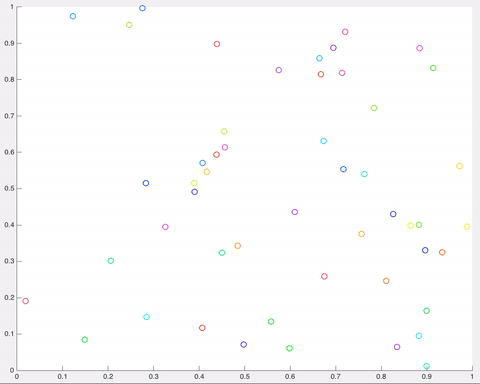

In [ ]:
from datetime import datetime
import sklearn
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hc

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering

In [ ]:
def plot_dendrogram(X, **kwargs):
    '''Plot Hierarchical Clustering Dendrogram.'''
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(X)
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [ ]:
X_sample = pd_rfm_scaled.copy()
X_sample = X_sample.sample(n=10000)
X_sample.name = "X_sample"
X_sample.shape

In [ ]:
#
# Create the clusters using Agglomerative hierarchical clustering
#
agc = AgglomerativeClustering(n_clusters = 4)

In [ ]:
X_sample_feat = X_sample[['frequency','monetary','recency']]
c = agc.fit_predict(X_sample_feat)

In [ ]:
plot_dendrogram(X_sample_feat, truncate_mode='level', p=4)

In [ ]:
plt.scatter(X_sample_feat['frequency'], X_sample_feat['monetary'], c = c, cmap ='rainbow')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()

In [ ]:
plt.scatter(X_sample_feat['recency'], X_sample_feat['frequency'], c = c, cmap ='rainbow')
plt.xlabel('recency')
plt.ylabel('frequency')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()

In [ ]:
plt.scatter(X_sample_feat['recency'], X_sample_feat['monetary'], c = c, cmap ='rainbow')
plt.xlabel('recency')
plt.ylabel('monetary')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()

## Ressources:

https://www.kaggle.com/rajivaiml/brazilian-ecommerce-eda-rfm-nmf#Lets-do-the-RFM-Analysis-for-the-Sellers

https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6

https://medium.com/swlh/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-93aa4c79f7a7

http://bilgisayarkavramlari.com/2008/12/15/k-ortalama-algoritmasi-k-means-algorithm/?highlight=clustering

https://github.com/opsabarsec/E-commerce-customers-automatic-clustering

https://github.com/nalron/project_segmentation_e-commerce_customers

## Description des datasets

* **Customers Dataset**:
This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.
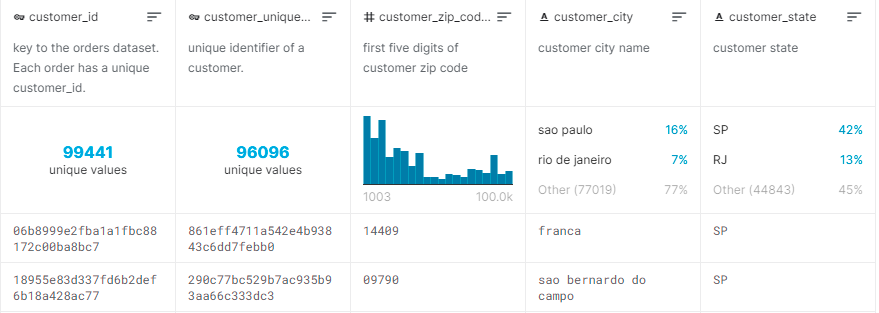


* **Geolocation Dataset**:
This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.
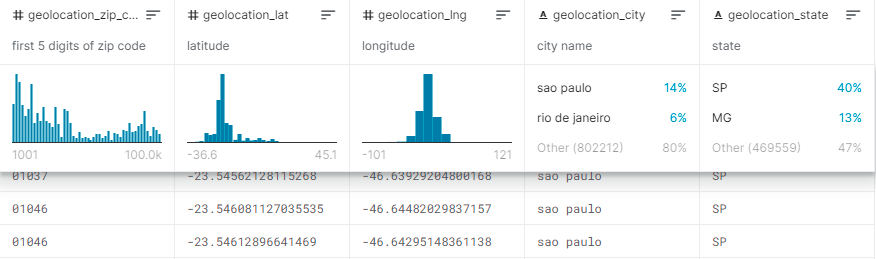


* **Order Items Dataset**:
This dataset includes data about the items purchased within each order.<br>
Example:
The order_id = 00143d0f86d6fbd9f9b38ab440ac16f5 has 3 items (same product). Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.<br>
The total order_item value is: 21.33 * 3 = 63.99 <br>
The total freight value is: 15.10 * 3 = 45.30 <br>
The total order value (product + freight) is: 45.30 + 63.99 = 109.29 
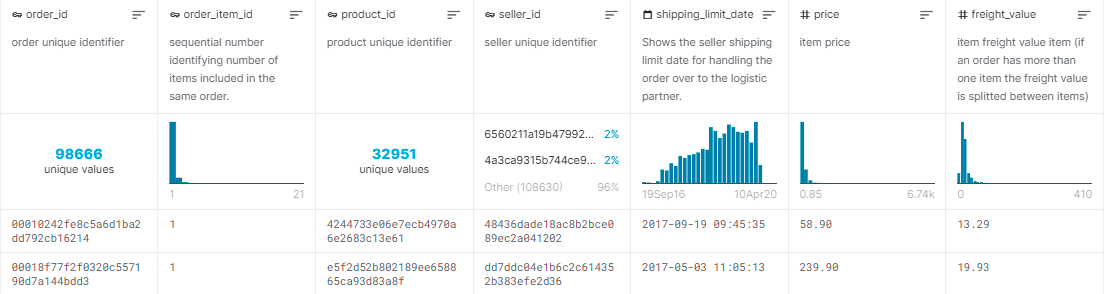


* **Payments Dataset**: 
This dataset includes data about the orders payment options.
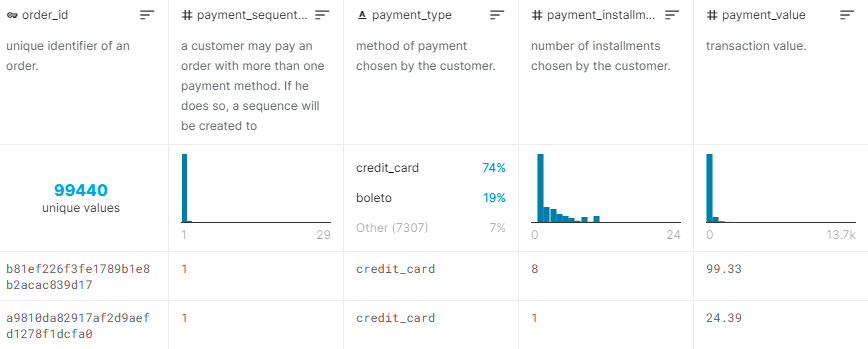


* **Order Reviews Dataset**: 
This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.
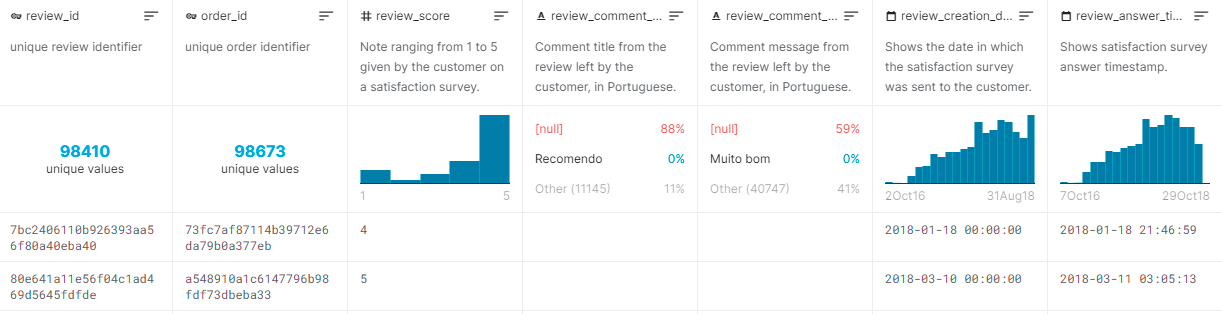


* **Order Dataset**:
This is the core dataset. From each order you might find all other information.
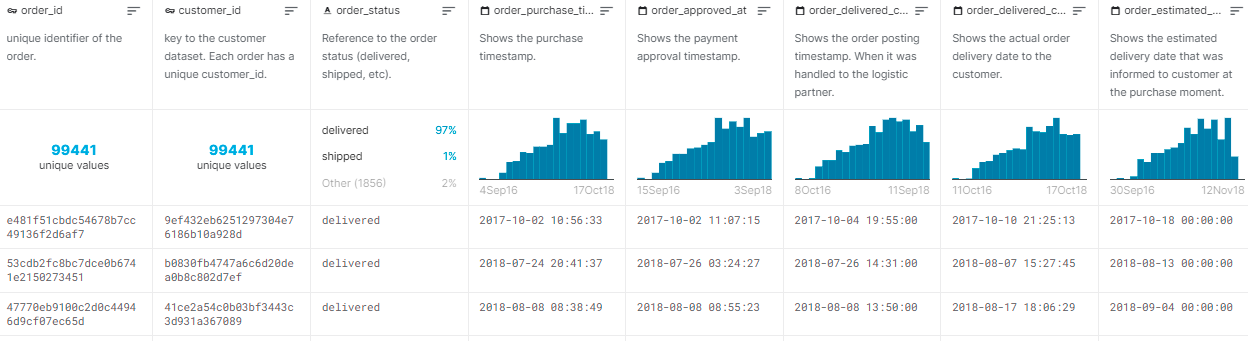


* **Products Dataset**:
This dataset includes data about the products sold by Olist.
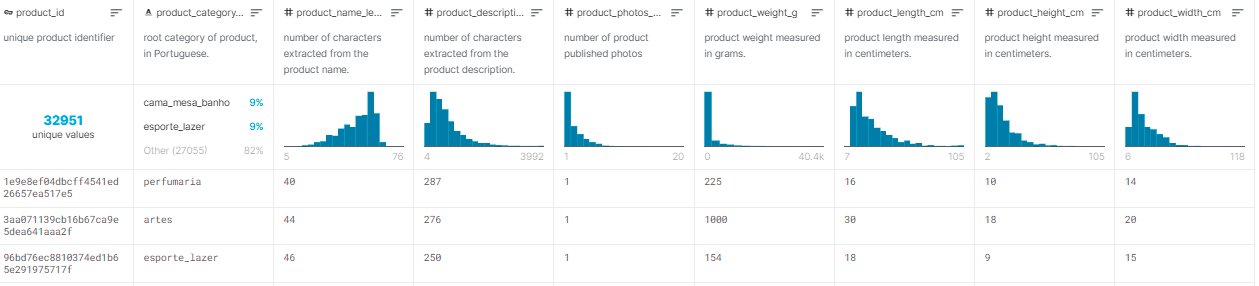


* **Sellers Dataset**:
This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.
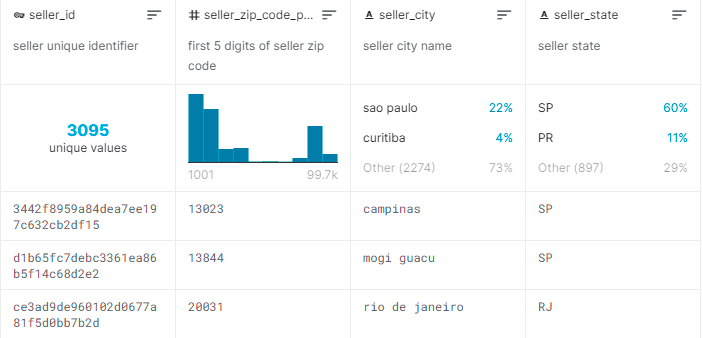


* **Category Name Translation**:
Translates the productcategoryname to english.
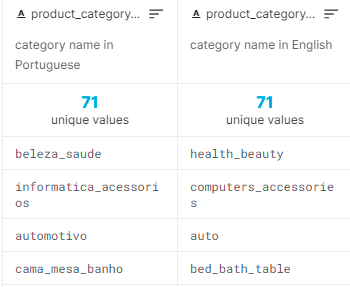